## Table of contents

0. [Importing libraries](#Importing-libraries)

1. [Step 1 : Business Understanding and Evaluation Metrics](#Step-1:-Business-Understanding-and-Evaluation-Metrics)

2. [Step 2: Data Understanding](#Step-2:-Data-Understanding)
    - [2.1. Data collection](#2.1.-Data-collection)
    - [2.2. Data description and Visualization](#2.2.-Data-description-and-visualization)
3. [Step 3: Data preparation](#Step-3:-Data-preparation)
    - [3.1. Data selection](#3.1.-Data-selection)
    - [3.2. Data Cleaning](#3.2-Data-Cleaning)
    - [3.3. Feature engineering](#3.3.-Feature-engineering)

4. [Step 4: Modeling](#Step-4:-Modeling)

5. [CONCLUSION :  ENHANCEMENT POSSIBILITIES and CODE REPRODUCTIBILITY](#CONCLUSION-:-ENHANCEMENT-POSSIBILITIES-and-CODE-REPRODUCTIBILITY)

## Importing libraries

In [1]:
import sys
!{sys.executable} -m pip install xgboost

# This line tells the notebook to show plots inside of the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate,cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as sgb
from xgboost import XGBClassifier
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import warnings
warnings.filterwarnings('ignore')

## Step 1: Business Understanding and Evaluation Metrics

[[ go back to the top ]](#Table-of-contents)

The first step to any data analysis project is to define the question or problem we're looking to solve, and to define a measure (or set of measures) for our success at solving that task. The data analysis checklist has us answer a handful of questions to accomplish that, so let's work through those questions.

>**Business goal** : We want to build a model which can predict a car consumption efficiency based on several attributed. A car is considered to be efficient if it has a Miles per gallon greater than 23. The answer requested is if a car consumption is efficient or not.



>**Evaluation metrics** : Since we are in a binary classification, we will test our model against accuray. But to fine tune our models we will look at metrics like AUC/ROC, F1 score.


<hr />

## Step 2: Data Understanding

[[ go back to the top ]](#Table-of-contents)

Here we are going to describe several steps that will allow us to better understand our data. How are going to collect our data, what our data looks like, are there missing ou weird values, what is the quality of our data and so on
<hr />


### 2.1. Data collection
[[ go back to the top ]](#Table-of-contents)

We are extracting data from a csv file from a cloud object storage in IBM. So we will just use our credentials to get the data. The format is csv, so it is already structured.

In [3]:
#df_data = pd.read_csv(body)
df_data = pd.read_csv("EMGrenoble_CarPerformance_Data.csv")
print("The shape of the data is : {}".format(df_data.shape))
df_data.head()

The shape of the data is : (406, 9)


,mpg,cylinders,engine,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,American,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,American,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,American,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,American,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,American,ford torino


### 2.2. Data description and visualization
[[ go back to the top ]](#Table-of-contents)


**First descriptive statistics**

In [4]:
df_data.describe()

,mpg,cylinders,engine,horsepower,weight,acceleration,year
count,398.000000,406.000000,406.000000,400.000000,406.000000,406.000000,406.000000
mean,23.514573,5.475369,194.779557,105.082500,2979.413793,15.519704,75.921182
std,7.815984,1.712160,104.922458,38.768779,847.004328,2.803359,3.748737
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,105.000000,75.750000,2226.500000,13.700000,73.000000
50%,23.000000,4.000000,151.000000,95.000000,2822.500000,15.500000,76.000000
75%,29.000000,8.000000,302.000000,130.000000,3618.250000,17.175000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


We have a total of 406 data entries, and 9 attributes describing our data.
We're in luck! The data seems to be in a usable format.

We can see that our descriptive attributes consist on : 
 * **Cylinders** : number of cylinder of the car engine. Numerical and Discrete ranging from 3 to 8
 * **Engine** : Continuous variable ranging from 68.0 to 455.0
 * **horsepower** : Continuous variable ranging from 46.0 to 230.0
 * **weight** : Continuous variable ranging from 1613.0 to 5140.0
 * **acceleration** : COntinuous variable ranging from 8.0 to 24.8
 * **year** : Numerical and discrete variable ranging from 70 to 82
 * **origin** : The origin of the car model. Nominal variable
 * **name** : Name of the car model . Nominal variable

And the target is the **mpg**  attribute which is continuous, so we have to transform it into a binary variable. The mpg in our dataset range from 9.0 to 46.6 and the business define an efficient car as having an mpg > 23.0 

**Main highlights from this table:**
   * The mean value of mpg is 23.51 so our data are relatively well distributed around efficient and non efficient cars.
   * The mpg max value is 46.6 which is far away than the mean+2*std, and also far away from the 75% percentile. So maybe we have outliers in our dataset
   * Same comment about outliers concerning engine
   * The range values of weight is 10 times greater than from the range of attributes like cylinder, acceleration. So maybe we will need to scale our data
   
We will do some data visualizing in the next steps to check our well our data are distributed

**Data quality : Checking of null or empty values**

In [5]:
df_data.isnull().sum()

mpg             8
cylinders       0
engine          0
horsepower      6
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [6]:
print("PERCENTENGE OF EMPTY VALUES")
print(df_data.isna().sum()*100/df_data.shape[0])

PERCENTENGE OF EMPTY VALUES
mpg             1.970443
cylinders       0.000000
engine          0.000000
horsepower      1.477833
weight          0.000000
acceleration    0.000000
year            0.000000
origin          0.000000
name            0.000000
dtype: float64


We can see that mpg has 8 undefined values, and horsepower has 6 undefined values. 3.5% (less than 5%) of our total data set. 
We will plot distributions of data to see how to handle missing values and outliers.

Let's start by printing out some summary statistics about the data set :

**Pre data engineering**

We are going to do some first transformation on the dataset before visualizing it. Notably, we want to introduce here the effiency attribute which will tell if a car is efficient or not. Advanced data preparation (such as how we will deal with nominal variables) will be done further.

In [7]:
df_data.loc[df_data['mpg'] > 23.0,"car_efficiency"] = '1'
df_data.loc[df_data['mpg'] <= 23.0,"car_efficiency"] = '0'

In [8]:
df_data.head()

,mpg,cylinders,engine,horsepower,weight,acceleration,year,origin,name,car_efficiency
0,18.0,8,307.0,130.0,3504,12.0,70,American,chevrolet chevelle malibu,0
1,15.0,8,350.0,165.0,3693,11.5,70,American,buick skylark 320,0
2,18.0,8,318.0,150.0,3436,11.0,70,American,plymouth satellite,0
3,16.0,8,304.0,150.0,3433,12.0,70,American,amc rebel sst,0
4,17.0,8,302.0,140.0,3449,10.5,70,American,ford torino,0


#### **Data Visualizations** 

**A. Focus on numerical variables**

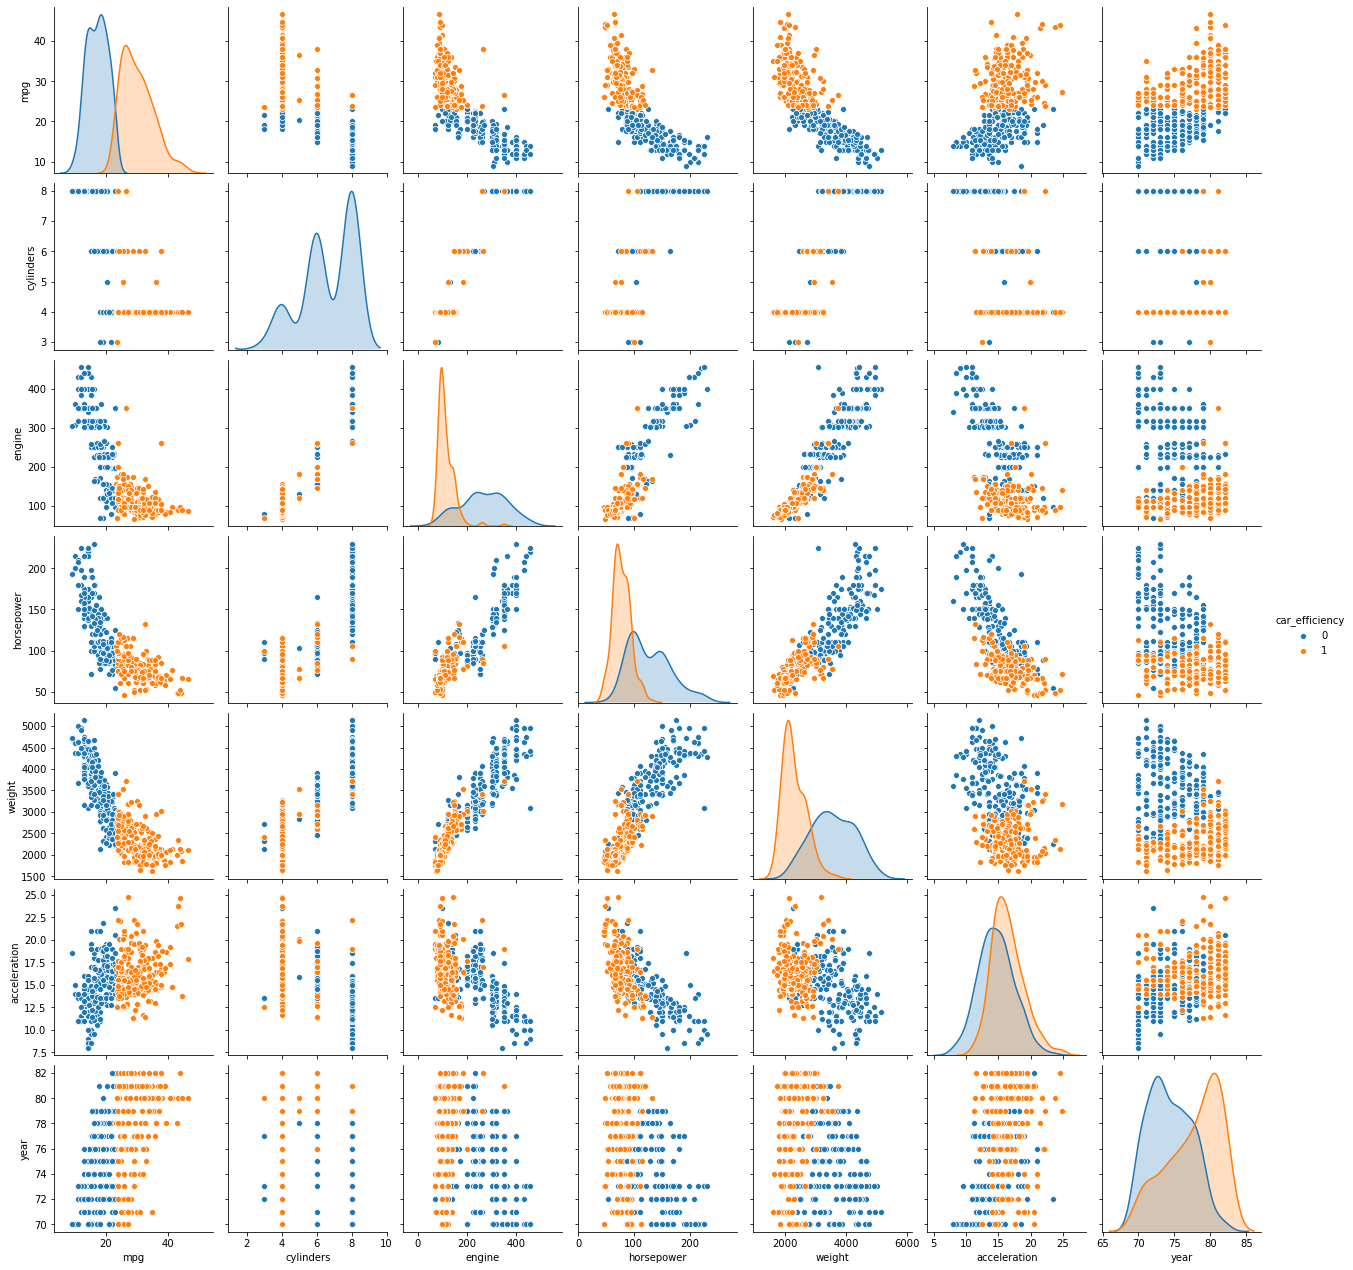

In [9]:
# We have to temporarily drop the rows with 'NA' values because the Seaborn plotting function does not know what to do with them
sns.pairplot(df_data,hue="car_efficiency")

Main highlights from the dataset:
1. Majority of Efficient car have 4 cylinders and can also have 6 cylinders, while the vast majority of non efficient cars have 6 cylinders. **1st hypothesis : The more cylinders, the least efficient**

2. Allmost all efficient cars have an engine of less than 200 engine units. We can see some values outside the distribution of engine values, maybe outliers ? We will check it in the boxplot visualization. **2nd hypothesis : Efficient cars have a mean value around 150 units**

3. After the 80s, most manufactured cars are efficient. That seems normal, since the technology has evolved.

4. **We can see strong correlations between some of our explanatory variables.** In fact the are strong correlation between horse power and weight, horse power and accelaration. Also between engine and weight, engine and horsepower, weight and horse power. **All those correlations can introduce some kind of colinearity inside our modelisation** and we need to take care of it. We can confirme those correlation with the heatmap below

5. There are also some visible correlation between the mpg variable and some explanatory variables. This is good to know since it can give us so intuition about the type of models to use

6. Globally our continuous variables are normally distributed or log normally distributed (e.g: horsepower, engine,weight), because of skewness

7. For outliers we will plot box plot to check them

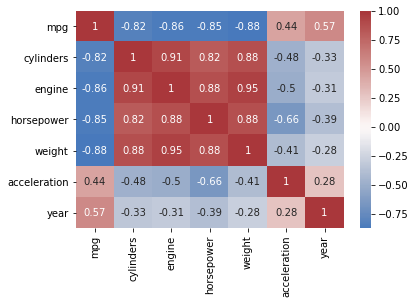

In [10]:
sns.heatmap(df_data.dropna().corr(method="spearman"),cmap="vlag",center=0,annot=True)

#### [**Outliers checking**](#Boxplot)

We will exclude the number of cylinders from this case since it is a discrete variable and study it right after this
Boxplot
Histogram for cylinders

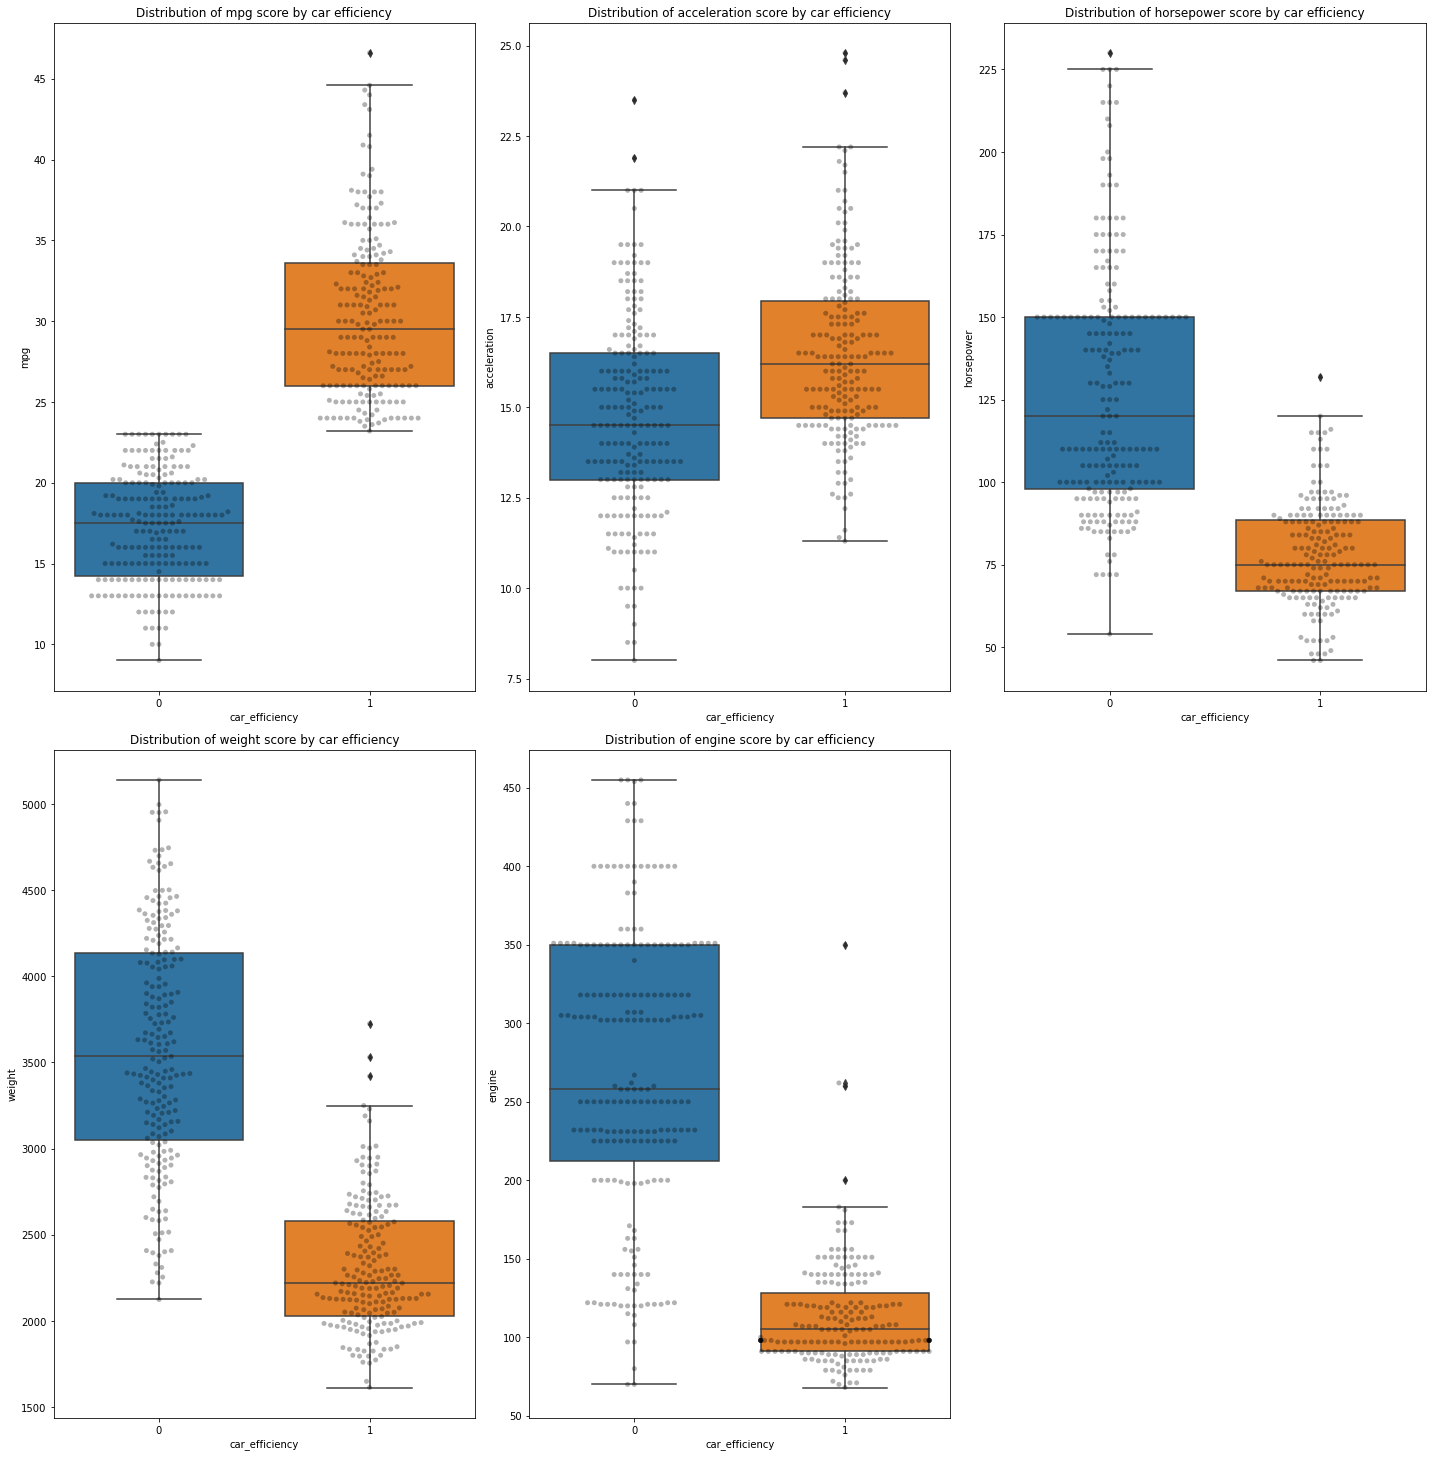

In [11]:
continuous_variables = ["mpg","acceleration","horsepower","weight","engine"]
num_variable = len(continuous_variables)
n = np.ceil(np.sqrt(len(continuous_variables)))
plt.figure(figsize=(20,30),tight_layout=True)
for i,c in enumerate(continuous_variables):
    plt.subplot(n,n,i+1)
    ax = sns.boxplot(data=df_data[[c,"car_efficiency"]],x="car_efficiency",y=c)
    ax = sns.swarmplot(data=df_data[[c,"car_efficiency"]],x="car_efficiency",y=c,color="black",alpha=0.3)
    ax.set_title("Distribution of %s score by car efficiency"%c)

plt.show()

**Main highlights**

Those boxplots offer to us more interesting insights from our dataset

1. **75% of efficient cars have less than ~85 horsepower units** while 75% of unefficient cars have horsepower greater than 99 horsepower units

2. **Almost all efficient cars have an engine value less than 200 engine units.** That is in line with our second hypothesis stated before. We can see few value above 200 engine units, and that can be seen as outliers.

3. **Almost all values of weight for efficient cars are below 3250 weight units**

4. Concerning the engine box plot, we have some exteremly high values fro efficient cars, compared to the mean and to the 75 percentile

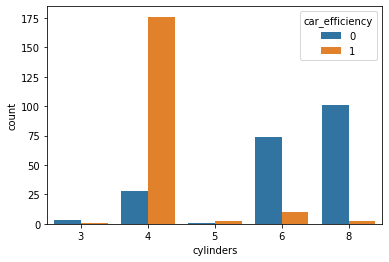

********************** Efficient cars count per number of cylinders******************
           car_efficiency
cylinders                
3                       1
4                     176
5                       2
6                      10
8                       2
********************** INEfficient cars count per number of cylinders******************
           car_efficiency
cylinders                
3                       3
4                      28
5                       1
6                      74
8                     101


In [12]:
ax = sns.countplot(data=df_data[["cylinders","car_efficiency"]], x="cylinders",hue="car_efficiency",dodge=True)
plt.show()
print("********************** Efficient cars count per number of cylinders******************")
print(df_data.loc[df_data["car_efficiency"]=='1',["cylinders","car_efficiency"]].groupby("cylinders").count())
print("********************** INEfficient cars count per number of cylinders******************")
print(df_data.loc[df_data["car_efficiency"]=='0',["cylinders","car_efficiency"]].groupby("cylinders").count())

* **Just 3 cars (2 efficient cars and 1 inefficient car) in total with 5 cylinders. We may not have enough information to describe 5 cylinders cars.**
* **Only 4 cars (1 effient and 3 inefficient) in total with 3 cylinders.**
* **Only 2 efficient carz with 8 cylinders. That's weird. Either that car is very special or it is a mistake.**

**B. Focus on nominal variables**

Let us focus a little bit on the nominal variables. We will consider here the Origin variable. We consider the name has no impact on the car performance since it is just a denomination.

In [13]:
print(df_data["origin"].unique())
df_data.loc[:,["origin","car_efficiency"]].groupby("origin").count()

['American' 'European' 'Japanese']


,car_efficiency
origin,
American,249
European,70
Japanese,79


We have just 3 possible values for the origin variable. Either it is an American, European or Japanese car.

Most cars in our data set are American cars. So our data is not well balanced concerning this attribute. We will need to take care of that when designing our model and when analyzing our model result

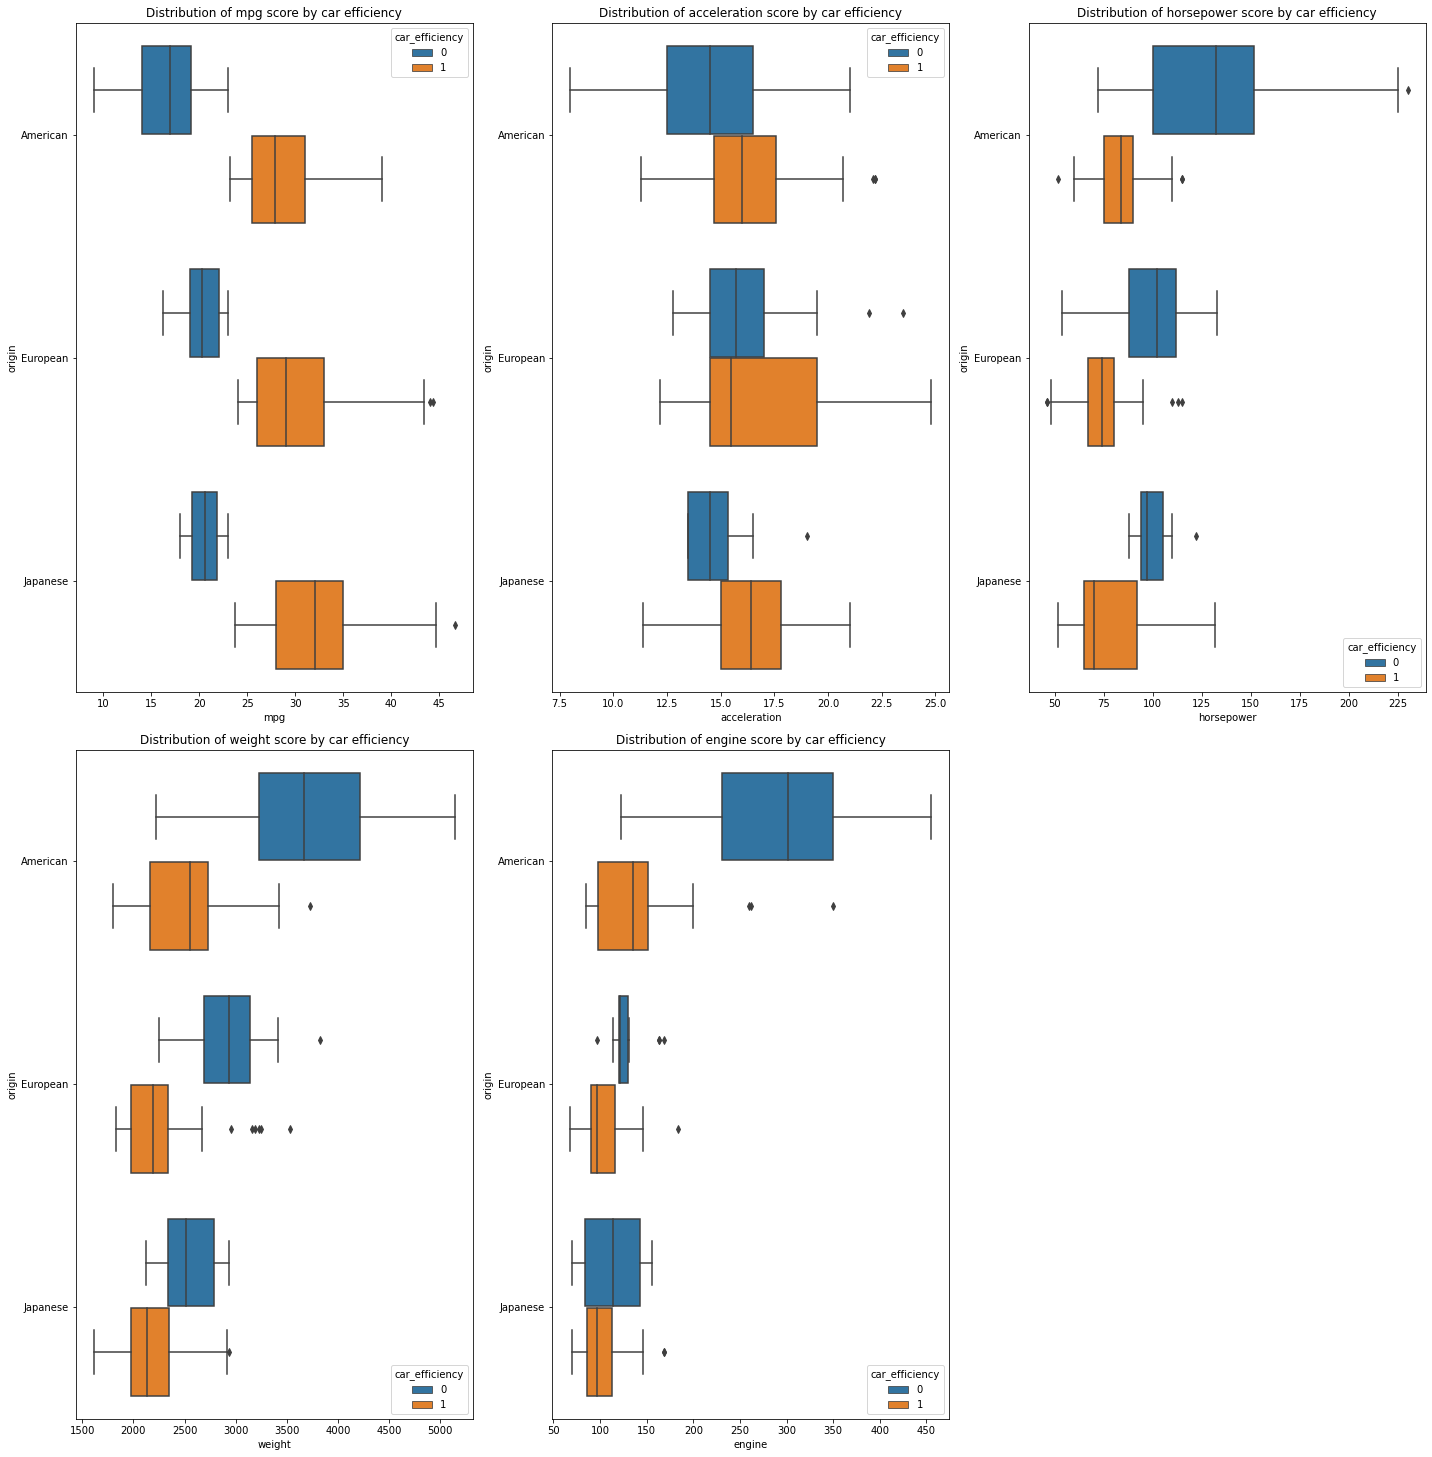

In [14]:
continuous_variables = ["mpg","acceleration","horsepower","weight","engine"]
num_variable = len(continuous_variables)
n = np.ceil(np.sqrt(len(continuous_variables)))
plt.figure(figsize=(20,30),tight_layout=True)
for i,c in enumerate(continuous_variables):
    plt.subplot(n,n,i+1)
    ax = sns.boxplot(x=c, y="origin", data=df_data,hue="car_efficiency")
    #ax = sns.swarmplot(data=df_data,x=c,y="origin",color="black",alpha=0.3,hue='car_efficiency')
    ax.set_title("Distribution of %s score by car efficiency"%c)

plt.show()

#sns.boxplot(x="mpg", y="origin", data=df_data,hue="car_efficiency", palette="vlag")

<hr />

## Step 3: Data preparation

[[ go back to the top ]](#Table-of-contents)

Here we are going to transform our dataset and prepare it for the modeling form. Thus we need to deal with missing values, outliers. Create if necessary new features to represent our nominal variables.

### 3.1. Data selection
[[ go back to the top ]](#Table-of-contents)

We are going to select as explanatory variables : **"mpg","acceleration","horsepower","weight","engine","origin","year"**.

We want to predict **car efficiency**

We exlude the variable "name" since it has nothing to do into the manufacturing process of a car


### 3.2. Data cleaning

**Missing Values**

   **a. MPG/Car_efficiency missing values**

In [15]:
df_data[df_data["mpg"].isna()]

,mpg,cylinders,engine,horsepower,weight,acceleration,year,origin,name,car_efficiency
10,NaN,8,350.0,165.0,4142,11.5,70,American,chevrolet chevelle concours (sw),NaN
11,NaN,8,351.0,153.0,4034,11.0,70,American,ford torino (sw),NaN
12,NaN,8,383.0,175.0,4166,10.5,70,American,plymouth satellite (sw),NaN
13,NaN,8,360.0,175.0,3850,11.0,70,American,amc rebel sst (sw),NaN
16,NaN,8,302.0,140.0,3353,8.0,70,American,ford mustang boss 302,NaN
254,NaN,4,133.0,115.0,3090,17.5,70,European,citroen ds-21 pallas,NaN
260,NaN,4,97.0,48.0,1978,20.0,71,European,volkswagen super beetle 117,NaN
323,NaN,4,121.0,110.0,2800,15.4,81,European,saab 900s,NaN


We have multiple strategies available for us here:

* The 5 first values have an engine value really high, greater than 300, but from [[ our box plot in the visualization part ]](#Outliers-checking), we saw that almost all cars having such engine values are non efficient cars. Then we can set mpg values to zero. But be careful than it has an impact on the model we are going to choose. For example, we cannot use linear regression (before truncatin on the value 23), because we do not have mpg value, we are just setting a car efficiency value. The 3 last values follow the same logic, have a high probability to be efficient cars.

* Those data just represent 2% of our data and are not strongly representative of a group of entries in our , we can safely delete them

**We will apply the first strategy**

In [16]:
dataset_clean = df_data

In [17]:
dataset_clean.loc[[10,11,12,13,16],"car_efficiency"]='0'
dataset_clean.loc[[254,260,323],"car_efficiency"]='1'
dataset_clean[dataset_clean["mpg"].isna()]

,mpg,cylinders,engine,horsepower,weight,acceleration,year,origin,name,car_efficiency
10,NaN,8,350.0,165.0,4142,11.5,70,American,chevrolet chevelle concours (sw),0
11,NaN,8,351.0,153.0,4034,11.0,70,American,ford torino (sw),0
12,NaN,8,383.0,175.0,4166,10.5,70,American,plymouth satellite (sw),0
13,NaN,8,360.0,175.0,3850,11.0,70,American,amc rebel sst (sw),0
16,NaN,8,302.0,140.0,3353,8.0,70,American,ford mustang boss 302,0
254,NaN,4,133.0,115.0,3090,17.5,70,European,citroen ds-21 pallas,1
260,NaN,4,97.0,48.0,1978,20.0,71,European,volkswagen super beetle 117,1
323,NaN,4,121.0,110.0,2800,15.4,81,European,saab 900s,1


**We have successfully fill the car_efficiency column**

**b. Horsepower missing values**

In [18]:
df_data[df_data["horsepower"].isna()]

,mpg,cylinders,engine,horsepower,weight,acceleration,year,origin,name,car_efficiency
28,25.0,4,98.0,NaN,2046,19.0,71,American,ford pinto,1
95,21.0,6,200.0,NaN,2875,17.0,74,American,ford maverick,0
220,23.6,4,140.0,NaN,2905,14.3,80,American,ford mustang cobra,1
241,23.0,4,151.0,NaN,3035,20.5,82,American,amc concord dl,0
317,40.9,4,85.0,NaN,1835,17.3,80,European,renault lecar deluxe,1
321,34.5,4,100.0,NaN,2320,15.8,81,European,renault 18i,1


We can propose 3 strategies to handle those missing values :
* We have the car_efficiency class of each entries, we can then replace their value by the mean value of horsepower according to the car_efficiency class the entry belong
* We know from the visualization steps that weight and horsepower are strongly correlated. Thus we can determine the relationship between horsepower and weight (horsepower ~ weight), and then apply the obtained model on missing horsepower values
* We just have 6 missing values, they represent barely 1.5% of our total sample, we can then safely delete them.

**We will implement here the first strategy**

In [19]:
horsepower_mean_for_efficient_car = dataset_clean.loc[dataset_clean["car_efficiency"]=='1',"horsepower"].mean()
dataset_clean.loc[(dataset_clean["horsepower"].isna()) & (dataset_clean["car_efficiency"]=='1'),["horsepower"]] = horsepower_mean_for_efficient_car


horsepower_mean_for_non_efficient_car = dataset_clean.loc[dataset_clean["car_efficiency"]=='0',"horsepower"].mean()
dataset_clean.loc[(dataset_clean["horsepower"].isna()) & (dataset_clean["car_efficiency"]=='0'),["horsepower"]] = horsepower_mean_for_non_efficient_car


In [20]:
dataset_clean.loc[[28,95,220,241,317,321]]

,mpg,cylinders,engine,horsepower,weight,acceleration,year,origin,name,car_efficiency
28,25.0,4,98.0,78.536842,2046,19.0,71,American,ford pinto,1
95,21.0,6,200.0,129.100000,2875,17.0,74,American,ford maverick,0
220,23.6,4,140.0,78.536842,2905,14.3,80,American,ford mustang cobra,1
241,23.0,4,151.0,129.100000,3035,20.5,82,American,amc concord dl,0
317,40.9,4,85.0,78.536842,1835,17.3,80,European,renault lecar deluxe,1
321,34.5,4,100.0,78.536842,2320,15.8,81,European,renault 18i,1


**Outliers**

We emit some doubt previously concerning car with 3,5 and 8 (only performing cars in this case) cylinders.
Let's see what are those cars

In [21]:
dataset_clean[(dataset_clean["cylinders"]==8) & (dataset_clean["car_efficiency"]=='1')]

,mpg,cylinders,engine,horsepower,weight,acceleration,year,origin,name,car_efficiency
207,23.9,8,260.0,90.0,3420,22.2,79,American,oldsmobile cutlass salon brougham,1
231,26.6,8,350.0,105.0,3725,19.0,81,American,oldsmobile cutlass ls,1


In [22]:
dataset_clean[(dataset_clean["cylinders"]==3)]

,mpg,cylinders,engine,horsepower,weight,acceleration,year,origin,name,car_efficiency
334,19.0,3,70.0,97.0,2330,13.5,72,Japanese,mazda rx2 coupe,0
340,18.0,3,70.0,90.0,2124,13.5,73,Japanese,maxda rx3,0
361,21.5,3,80.0,110.0,2720,13.5,77,Japanese,mazda rx-4,0
383,23.7,3,70.0,100.0,2420,12.5,80,Japanese,mazda rx-7 gs,1


In [23]:
dataset_clean[(dataset_clean["cylinders"]==5)]

,mpg,cylinders,engine,horsepower,weight,acceleration,year,origin,name,car_efficiency
302,20.3,5,131.0,103.0,2830,15.9,78,European,audi 5000,0
308,25.4,5,183.0,77.0,3530,20.1,79,European,mercedes benz 300d,1
315,36.4,5,121.0,67.0,2950,19.9,80,European,audi 5000s (diesel),1


**Since we do not have enough intuition from the business about the coherence of those data, we are going tolerate them into our models, just like other potential weird values. We may make some test after to see if those data impact our model**

### 3.3. Feature engineering
[[ go back to the top ]](#Table-of-contents)

We have to build the features we are going to use for our future models.

* **Drop "mpg" and "name" columns**
* **Create dummy variables for the variable "origin", and use one hot encoding for it**

In [24]:
dataset_clean.drop(columns=["mpg","name"],inplace=True)

In [25]:
dataset_clean

,cylinders,engine,horsepower,weight,acceleration,year,origin,car_efficiency
0,8,307.0,130.0,3504,12.0,70,American,0
1,8,350.0,165.0,3693,11.5,70,American,0
2,8,318.0,150.0,3436,11.0,70,American,0
3,8,304.0,150.0,3433,12.0,70,American,0
4,8,302.0,140.0,3449,10.5,70,American,0
...,...,...,...,...,...,...,...,...
401,4,108.0,70.0,2245,16.9,82,Japanese,1
402,4,91.0,67.0,1965,15.0,82,Japanese,1
403,4,91.0,67.0,1965,15.7,82,Japanese,1
404,4,91.0,67.0,1995,16.2,82,Japanese,1


In [26]:
explanatory_variables= ["acceleration","horsepower","weight","engine","cylinders","year","origin"]
to_predict = ["car_efficiency"]

dataset_X = pd.get_dummies(data=dataset_clean[explanatory_variables],columns=["origin"],prefix=["origin"],drop_first=False)
dataset_y = dataset_clean[to_predict]

In [27]:
dataset_X

,acceleration,horsepower,weight,engine,cylinders,year,origin_American,origin_European,origin_Japanese
0,12.0,130.0,3504,307.0,8,70,1,0,0
1,11.5,165.0,3693,350.0,8,70,1,0,0
2,11.0,150.0,3436,318.0,8,70,1,0,0
3,12.0,150.0,3433,304.0,8,70,1,0,0
4,10.5,140.0,3449,302.0,8,70,1,0,0
...,...,...,...,...,...,...,...,...,...
401,16.9,70.0,2245,108.0,4,82,0,0,1
402,15.0,67.0,1965,91.0,4,82,0,0,1
403,15.7,67.0,1965,91.0,4,82,0,0,1
404,16.2,67.0,1995,91.0,4,82,0,0,1


In [28]:
dataset_y

,car_efficiency
0,0
1,0
2,0
3,0
4,0
...,...
401,1
402,1
403,1
404,1


<hr />

## Step 4: Modeling
[[ go back to the top ]](#Table-of-contents)

**Here comes the modeling step. We alredy know the metric which is accuracy. The problem is a classification problem, so we need to look for algorithms allowing us to perform such task.**

**GLobal Procedure**

Since we do not have enough data (just 406), we are going to use cross validation dataset where each data will serve once as a test data.

When dividing our data into fold, we will make sure that we have the same initial proportion of each class, in the train set and set

We are also going to use Grid Search to find the best parameters of each model family we are going to use


**Let us first set a baseline model so that we can test our future models against.**

### 4.1 Baseline Model

Our baseline model will always predict class 0 .

In [29]:
class BaselineModel:
    
    output = '0'
    
    def fit(self):
        self.output = '0'

    def predict(self, y_vector_shape):

        return np.full(y_vector_shape,fill_value=self.output)

We can test our baseline model on our full dataset.

In [30]:
blm = BaselineModel()
blm.fit()
accuracy_score(dataset_y,blm.predict(dataset_y.shape))

0.5221674876847291

**We have a baseline accuracy of 52.2%**

### 4.2. Random Forest Classifiers

This model is not sensitive to colinearity and could be a good model.

In [31]:
grid_search_param = {
    'criterion' : ("gini","entropy"),
    "n_estimators": [1,5,10,50,100,500],
    "min_samples_split":[3,5,11],
    "warm_start":(False,True)
}

cross_validation_set = StratifiedKFold(n_splits=10,shuffle=True)

In [32]:
grid_search_clf = GridSearchCV(estimator=RandomForestClassifier(),param_grid=grid_search_param,scoring="accuracy",
                               cv=cross_validation_set,refit=True,verbose=2)

In [33]:
grid_search_clf.fit(dataset_X,dataset_y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] criterion=gini, min_samples_split=3, n_estimators=1, warm_start=False 
[CV]  criterion=gini, min_samples_split=3, n_estimators=1, warm_start=False, total=   0.0s
[CV] criterion=gini, min_samples_split=3, n_estimators=1, warm_start=False 
[CV]  criterion=gini, min_samples_split=3, n_estimators=1, warm_start=False, total=   0.0s
[CV] criterion=gini, min_samples_split=3, n_estimators=1, warm_start=False 
[CV]  criterion=gini, min_samples_split=3, n_estimators=1, warm_start=False, total=   0.0s
[CV] criterion=gini, min_samples_split=3, n_estimators=1, warm_start=False 
[CV]  criterion=gini, min_samples_split=3, n_estimators=1, warm_start=False, total=   0.0s
[CV] criterion=gini, min_samples_split=3, n_estimators=1, warm_start=False 
[CV]  criterion=gini, min_samples_split=3, n_estimators=1, warm_start=False, total=   0.0s
[CV] criterion=gini, min_samples_split=3, n_estimators=1, warm_start=False 
[CV]  criterion=gini, min_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False, total=   0.0s
[CV] criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False 
[CV]  criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False, total=   0.0s
[CV] criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False 
[CV]  criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False, total=   0.0s
[CV] criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False 
[CV]  criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False, total=   0.0s
[CV] criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False 
[CV]  criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False, total=   0.0s
[CV] criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False 
[CV]  criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False, total=   0.0s
[CV] criterion=gini, min_samples_split=3, n_estimators=5, warm_start=False

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  2.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'min_samples_split': [3, 5, 11],
                         'n_estimators': [1, 5, 10, 50, 100, 500],
                         'warm_start': (False, True)},
             scoring='accuracy', verbose=2)

In [34]:
grid_search_clf.best_score_

0.9335975609756095

In [35]:
grid_search_clf.cv_results_

{'mean_fit_time': array([0.00705481, 0.00694942, 0.01230416, 0.0120424 , 0.01900477,
        0.01907339, 0.07219739, 0.07269852, 0.13965065, 0.1391283 ,
        0.6606967 , 0.66415355, 0.00695205, 0.00666413, 0.01286325,
        0.01245961, 0.01930945, 0.01899381, 0.07062528, 0.07154896,
        0.13982923, 0.13861356, 0.66717544, 0.66958749, 0.00713534,
        0.00682075, 0.0122803 , 0.01307914, 0.02001801, 0.02086821,
        0.07474689, 0.07233405, 0.14027407, 0.1376462 , 0.65319433,
        0.66335764, 0.00704546, 0.00691512, 0.0128154 , 0.01296434,
        0.01933951, 0.01917698, 0.0735153 , 0.07459488, 0.14527056,
        0.14970107, 0.7173806 , 0.71659565, 0.00698898, 0.00703692,
        0.0126353 , 0.01253376, 0.02015233, 0.02004356, 0.07559359,
        0.07694945, 0.14472702, 0.14693329, 0.69718449, 0.69949675,
        0.00716674, 0.00687635, 0.01344416, 0.0128356 , 0.01930423,
        0.01893325, 0.07444861, 0.07340658, 0.1439682 , 0.1435816 ,
        0.69660754, 0.69142895]

In [36]:
 grid_search_clf.best_estimator_

RandomForestClassifier(criterion='entropy', min_samples_split=5, n_estimators=5)

In [37]:
rf_df = pd.DataFrame({'accuracy': cross_val_score( grid_search_clf.best_estimator_, dataset_X, dataset_y, cv=cross_validation_set),
                       'classifier': ['Random Forest'] * 10})

In [38]:
rf_df.describe()

,accuracy
count,10.000000
mean,0.916341
std,0.038545
min,0.853659
25%,0.884146
50%,0.925915
75%,0.944207
max,0.975610


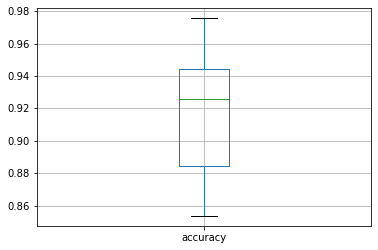

In [39]:
rf_df.boxplot()

### 4.3. Penalized Logistic Regression

In [40]:
grid_search_param_logit = {
    'penalty' : ("l1","l2","elasticnet"),
    "C": [10e-5,10e-4,10e-3,10e-2,10e-1,1.0,10,100,1000],
    "warm_start":(False,True),
    "solver":["liblinear","lbfgs","newton-cg","saga"]
}

cross_validation_set = StratifiedKFold(n_splits=10,shuffle=True)

In [41]:
grid_search_logit = GridSearchCV(estimator=LogisticRegression(fit_intercept=True,verbose=2),
                                param_grid=grid_search_param_logit,scoring="accuracy",cv=cross_validation_set,refit=True,
                                 verbose=2)

In [42]:
grid_search_logit.fit(dataset_X,dataset_y)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV] C=0.0001, penalty=l1, solver=liblinear, warm_start=False ........
[LibLinear][CV]  C=0.0001, penalty=l1, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l1, solver=liblinear, warm_start=False ........
[LibLinear][CV]  C=0.0001, penalty=l1, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l1, solver=liblinear, warm_start=False ........
[LibLinear][CV]  C=0.0001, penalty=l1, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l1, solver=liblinear, warm_start=False ........
[LibLinear][CV]  C=0.0001, penalty=l1, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l1, solver=liblinear, warm_start=False ........
[LibLinear][CV]  C=0.0001, penalty=l1, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l1, solver=liblinear, warm_start=False ........
[LibLinear][CV]  C=0.0001, penalty=l1, solver=liblinear, warm_st

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 18 epochs took 0 seconds
[CV]  C=0.0001, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l1, solver=saga, warm_start=False .............
convergence after 14 epochs took 0 seconds
[CV]  C=0.0001, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l1, solver=saga, warm_start=False .............
convergence after 22 epochs took 0 seconds
[CV]  C=0.0001, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l1, solver=saga, warm_start=False .............
convergence after 16 epochs took 0 seconds
[CV]  C=0.0001, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l1, solver=saga, warm_start=False .............
convergence after 20 epochs took 0 seconds
[CV]  C=0.0001, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l1, solver=saga, warm_start=False .............
convergence after 16 epochs took 0 seconds
[CV]  C=0.0001, penalt

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=0.0001, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=liblinear, warm_start=False ........
[LibLinear][CV]  C=0.0001, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=liblinear, warm_start=False ........
[LibLinear][CV]  C=0.0001, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=liblinear, warm_start=False ........
[LibLinear][CV]  C=0.0001, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=liblinear, warm_start=False ........
[LibLinear][CV]  C=0.0001, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=liblinear, warm_start=True .........
[LibLinear][CV]  C=0.0001, penalty=l2, solver=liblinear, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=liblinear, warm_start=True .........
[LibLinear][CV]  C=0.0001, penalty=l2, solver=liblin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=False ............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=False ............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=False ............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=False ............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=False ............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=False ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=False ............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=True .............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=True .............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=True .............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=True .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=True .............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=True .............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=True .............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=True .............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=True .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=lbfgs, warm_start=True .............
[CV]  C=0.0001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=False ........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=False ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=False ........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=False ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=False ........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=False ........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=False ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=False ........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=False ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=False ........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=True .........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=True .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=True .........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=True .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=True .........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=True .........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=True .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=True .........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=True .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=newton-cg, warm_start=True .........
[CV]  C=0.0001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.0001, penalty=l2, solver=saga, warm_start=False .............
max_iter reached after 0 seconds
[CV]  C=0.0001, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=saga, warm_start=False .............
max_iter reached after 0 seconds
[CV]  C=0.0001, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=saga, warm_start=False .............
max_iter reached after 0 seconds
[CV]  C=0.0001, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=saga, warm_start=False .............
max_iter reached after 0 seconds
[CV]  C=0.0001, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=saga, warm_start=False ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

max_iter reached after 0 seconds
[CV]  C=0.0001, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=saga, warm_start=True ..............
max_iter reached after 0 seconds
[CV]  C=0.0001, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=saga, warm_start=True ..............
max_iter reached after 0 seconds
[CV]  C=0.0001, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=saga, warm_start=True ..............
max_iter reached after 0 seconds
[CV]  C=0.0001, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=saga, warm_start=True ..............
max_iter reached after 0 seconds
[CV]  C=0.0001, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.0001, penalty=l2, solver=saga, warm_start=True ..............
max_iter reached after 0 seconds
[CV]  C=0.0001, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.0001,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=0.001, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l1, solver=saga, warm_start=False ..............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l1, solver=saga, warm_start=False ..............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l1, solver=saga, warm_start=False ..............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l1, solver=saga, warm_start=False ..............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l1, solver=saga, warm_start=False ..............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l1, solver=saga, warm_star

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l1, solver=saga, warm_start=True ...............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l1, solver=saga, warm_start=True ...............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l1, solver=saga, warm_start=True ...............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l1, solver=saga, warm_start=True ...............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=liblinear, warm_start=False .........
[LibLinear][CV]  C=0.001, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l2, solver=libl

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=False .............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=False .............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=False .............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=True ..............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=True ..............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=True ..............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=True ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=True ..............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=True ..............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=True ..............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=True ..............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=True ..............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs, warm_start=True ..............
[CV]  C=0.001, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=False .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=False .........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=False .........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=False .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=False .........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=False .........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=False .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=False .........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=False .........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=False .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=True ..........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=True ..........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=True ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=True ..........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=True ..........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=True ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=True ..........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=True ..........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=True ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.001, penalty=l2, solver=newton-cg, warm_start=True ..........
[CV]  C=0.001, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.001, penalty=l2, solver=saga, warm_start=False ..............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l2, solver=saga, warm_start=False ..............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l2, solver=saga, warm_start=False ..............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l2, solver=saga, warm_start=False ..............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l2, solver=saga, warm_start=False ..............
ma

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.001, penalty=l2, solver=saga, warm_start=True ...............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=saga, warm_start=True ...............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=saga, warm_start=True ...............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=saga, warm_start=True ...............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.001, penalty=l2, solver=saga, warm_start=True ...............
max_iter reached after 0 seconds
[CV]  C=0.001, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.001, penalt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

max_iter reached after 0 seconds
[CV] . C=0.01, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l1, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=0.01, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l1, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=0.01, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l1, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=0.01, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l1, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=0.01, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l1, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=0.01, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=0.01, penalty=l2, solver=liblinear, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=liblinear, warm_start=True ...........
[LibLinear][CV]  C=0.01, penalty=l2, solver=liblinear, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=liblinear, warm_start=True ...........
[LibLinear][CV]  C=0.01, penalty=l2, solver=liblinear, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=liblinear, warm_start=True ...........
[LibLinear][CV]  C=0.01, penalty=l2, solver=liblinear, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=True ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs, warm_start=True ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=0.01, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=False ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0

[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=False ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=False ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=True ...........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=True ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=True ...........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=True ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=True ...........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=True ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=True ...........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=True ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=True ...........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.01, penalty=l2, solver=newton-cg, warm_start=True ...........
[CV]  C=0.01, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.01, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=0.01, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=0.01, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=0.01, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=0.01, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=0.01, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=0.01, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=0.01, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=l2, solver=saga, warm_start=False

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV] . C=0.01, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=0.01, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=0.01, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=l2, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=0.01, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.01, penalty=elasticnet, solver=liblinear, warm_start=False ..
[CV]  C=0.01, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=elasticnet, solver=liblinear, warm_start=False ..
[CV]  C=0.01, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.01, penalty=elasticnet, solver=liblinear, warm_start=False ..
[CV]  C=0.01, penalty=e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

max_iter reached after 0 seconds
[CV] . C=0.1, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=0.1, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=0.1, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=0.1, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=0.1, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=0.1, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[LibLinear][CV]  C=0.1, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=0.1, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=0.1, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=0.1, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=0.1, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=0.1, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=0.1, penalty=l2, solver=liblinear, warm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=0.1, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=0.1, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=0.1, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=0.1, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=0.1, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=False ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=0.1, penalty=l2, solver=lbfgs, warm_start=False, total=   0.1s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=0.1, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=0.1, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=0.1, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=0.1, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=0.1, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=True ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV] . C=0.1, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=0.1, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=0.1, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=0.1, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=0.1, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=True ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV] . C=0.1, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=0.1, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=0.1, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.1, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=0.1, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=0.1, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=0.1, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=0.1, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=0.1, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=0.1, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=0.1, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=l2, solver=saga, warm_start=Fal

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

max_iter reached after 0 seconds
[CV] .. C=0.1, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=0.1, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=0.1, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=0.1, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=l2, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=0.1, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=elasticnet, solver=liblinear, warm_start=False ...
[CV]  C=0.1, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=elasticnet, solver=lib

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV] C=0.1, penalty=elasticnet, solver=saga, warm_start=False ........
[CV]  C=0.1, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=elasticnet, solver=saga, warm_start=False ........
[CV]  C=0.1, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=elasticnet, solver=saga, warm_start=False ........
[CV]  C=0.1, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=elasticnet, solver=saga, warm_start=False ........
[CV]  C=0.1, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV] C=0.1, penalty=elasticnet, solver=saga, warm_start=True .........
[CV]  C=0.1, penalty=elasticnet, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=elasticnet, solver=saga, warm_start=True .........
[CV]  C=0.1, penalty=elasticnet, solver=saga, warm_start=True, total=   0.0s
[CV] C=0.1, penalty=elasticnet, solver=saga, warm_start=True .........
[CV]  C=0.1, penalty=elasticnet, solv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=1.0, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=liblinea

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=1.0, penalty=l2, solver=liblinear, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=liblinear, warm_start=True ............
[LibLinear][CV]  C=1.0, penalty=l2, solver=liblinear, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................
max_iter r

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=liblinear, warm_start=False ...
[CV]  C=1.0, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=liblinear, warm_start=False ...
[CV]  C=1.0, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=liblinear, warm_start=Fa

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  C=1.0, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=saga, warm_start=False ........
[CV]  C=1.0, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=saga, warm_start=False ........
[CV]  C=1.0, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=saga, warm_start=False ........
[CV]  C=1.0, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=saga, warm_start=True .........
[CV]  C=1.0, penalty=elasticnet, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=saga, warm_start=True .........
[CV]  C=1.0, penalty=elasticnet, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=saga, warm_start=True .........
[CV]  C=1.0, penalty=elasticnet, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=elasticnet,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l1, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=1.0, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=liblinea

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=1.0, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=1.0, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=1.0, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=1.0, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=l

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=l2, solver=saga, warm_start=True .................
max_iter reached after 0 seconds
[CV] .. C=1.0, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=liblinear, warm_start=False ...
[CV]  C=1.0, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=liblinear, warm_start=False ...
[CV]  C=1.0, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=liblinear, warm_start=Fa

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

max_iter reached after 0 seconds
[CV] .. C=10, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=10, penalty=l1, solver=saga, warm_start=False .................
max_iter reached after 0 seconds
[CV] .. C=10, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=10, penalty=l1, solver=saga, warm_start=True ..................
max_iter reached after 0 seconds
[CV] ... C=10, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=10, penalty=l1, solver=saga, warm_start=True ..................
max_iter reached after 0 seconds
[CV] ... C=10, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=10, penalty=l1, solver=saga, warm_start=True ..................
max_iter reached after 0 seconds
[CV] ... C=10, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=10, penalty=l1, solver=saga, warm_start=True ..................
max_iter reached after 0 seconds
[CV] ... C=10, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=10, penalty=l1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=10, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear, warm_start=False ............
[LibLinear][CV]  C=10, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear, warm_start=False ............
[LibLinear][CV]  C=10, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear, warm_start=False ............
[LibLinear][CV]  C=10, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear, warm_start=False ............
[LibLinear][CV]  C=10, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear, warm_start=True .............
[LibLinear][CV]  C=10, penalty=l2, solver=liblinear, warm_start=True, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear, warm_start=True .............
[LibLinear][CV]  C=10, penalty=l2, solver=liblinear, warm_start=True, total=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV] . C=10, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=False ................
[CV] . C=10, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=False ................
[CV] . C=10, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=False ................
[CV] . C=10, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=False ................
[CV] . C=10, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=False ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV] . C=10, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=False ................
[CV] . C=10, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=False ................
[CV] . C=10, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=True .................
[CV] .. C=10, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=True .................
[CV] .. C=10, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=True .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV] .. C=10, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=True .................
[CV] .. C=10, penalty=l2, solver=lbfgs, warm_start=True, total=   0.1s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=True .................
[CV] .. C=10, penalty=l2, solver=lbfgs, warm_start=True, total=   0.1s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=True .................
[CV] .. C=10, penalty=l2, solver=lbfgs, warm_start=True, total=   0.1s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=True .................
[CV] .. C=10, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=True .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV] .. C=10, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=True .................
[CV] .. C=10, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs, warm_start=True .................
[CV] .. C=10, penalty=l2, solver=lbfgs, warm_start=True, total=   0.1s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=False ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=False ............
[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=False ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=False ............
[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=False ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=False ............
[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=False ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=False ............
[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=False ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=False ............
[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=True .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=True .............
[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=True .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=True .............
[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=True .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=True .............
[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=True .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=True .............
[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=True .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=10, penalty=l2, solver=newton-cg, warm_start=True .............
[CV]  C=10, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=10, penalty=l2, solver=saga, warm_start=False .................
max_iter reached after 0 seconds
[CV] .. C=10, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=saga, warm_start=False .................
max_iter reached after 0 seconds
[CV] .. C=10, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=saga, warm_start=False .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

max_iter reached after 0 seconds
[CV] .. C=10, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=saga, warm_start=False .................
max_iter reached after 0 seconds
[CV] .. C=10, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=saga, warm_start=False .................
max_iter reached after 0 seconds
[CV] .. C=10, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=saga, warm_start=False .................
max_iter reached after 0 seconds
[CV] .. C=10, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=saga, warm_start=False .................
max_iter reached after 0 seconds
[CV] .. C=10, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2, solver=saga, warm_start=False .................
max_iter reached after 0 seconds
[CV] .. C=10, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=10, penalty=l2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

max_iter reached after 0 seconds
[CV] ... C=10, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=10, penalty=l2, solver=saga, warm_start=True ..................
max_iter reached after 0 seconds
[CV] ... C=10, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=10, penalty=elasticnet, solver=liblinear, warm_start=False ....
[CV]  C=10, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=10, penalty=elasticnet, solver=liblinear, warm_start=False ....
[CV]  C=10, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=10, penalty=elasticnet, solver=liblinear, warm_start=False ....
[CV]  C=10, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=10, penalty=elasticnet, solver=liblinear, warm_start=False ....
[CV]  C=10, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=10, penalty=elasticnet, solver=liblinear, warm_start=False ....
[CV]  C=10, penalty=elasticnet, solver

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV] . C=100, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=100, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=100, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=100, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=100, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=100, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=100, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=100, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=100, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=100, penalty=l1, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=100, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=100, penalty=l1, solver=saga, warm_start=True .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[LibLinear][CV]  C=100, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=100, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=100, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=100, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=100, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=100, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=liblinear, warm_start=False ...........
[LibLinear][CV]  C=100, penalty=l2, solver=liblinear, warm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=100, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=100, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=100, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=100, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=100, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=100, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=False ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=100, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=100, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=False ...............
[CV]  C=100, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=100, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=100, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=100, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=True ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV] . C=100, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=100, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=100, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=100, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=100, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=True ................
[CV] . C=100, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs, warm_start=True ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=100, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=False, total=   0.1s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=False ...........
[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=False ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=True ............
[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=100, penalty=l2, solver=newton-cg, warm_start=True ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=100, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=100, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=100, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=100, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=100, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=100, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=saga, warm_start=False ................
max_iter reached after 0 seconds
[CV] . C=100, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=100, penalty=l2, solver=saga, warm_start=Fal

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=100, penalty=elasticnet, solver=newton-cg, warm_start=True, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=newton-cg, warm_start=True ....
[CV]  C=100, penalty=elasticnet, solver=newton-cg, warm_start=True, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=newton-cg, warm_start=True ....
[CV]  C=100, penalty=elasticnet, solver=newton-cg, warm_start=True, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=newton-cg, warm_start=True ....
[CV]  C=100, penalty=elasticnet, solver=newton-cg, warm_start=True, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=newton-cg, warm_start=True ....
[CV]  C=100, penalty=elasticnet, solver=newton-cg, warm_start=True, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=newton-cg, warm_start=True ....
[CV]  C=100, penalty=elasticnet, solver=newton-cg, warm_start=True, total=   0.0s
[CV] C=100, penalty=elasticnet, solver=saga, warm_start=False ........
[CV]  C=100, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

max_iter reached after 0 seconds
[CV]  C=1000, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l1, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=1000, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l1, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=1000, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l1, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=1000, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l1, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=1000, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l1, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=1000, penalty=l1, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

max_iter reached after 0 seconds
[CV] . C=1000, penalty=l1, solver=saga, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=liblinear, warm_start=False ..........
[LibLinear][CV]  C=1000, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=liblinear, warm_start=False ..........
[LibLinear][CV]  C=1000, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=liblinear, warm_start=False ..........
[LibLinear][CV]  C=1000, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=liblinear, warm_start=False ..........
[LibLinear][CV]  C=1000, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=liblinear, warm_start=False ..........
[LibLinear][CV]  C=1000, penalty=l2, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=liblinear, warm_start=False ..........
[LibLinear][CV]  C=1000, penalty=l2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=False ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=False ..............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=True ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=True ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=True, total=   0.1s
[CV] C=1000, penalty=l2, solver=lbfgs, warm_start=True ...............
[CV]  C=1000, penalty=l2, solver=lbfgs, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=False ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=False ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=False ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=False ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=False ..........
[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=False ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=False, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=True ...........
[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=True, total=   0.1s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=True ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=True ...........
[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=True ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=True ...........
[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=True ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=True ...........
[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=True ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=True ...........
[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1000, penalty=l2, solver=newton-cg, warm_start=True ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1000, penalty=l2, solver=newton-cg, warm_start=True, total=   0.2s
[CV] C=1000, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=1000, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=1000, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=1000, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=1000, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=saga, warm_start=False ...............
max_iter reached after 0 seconds
[CV]  C=1000, penalty=l2, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=l2, solver=saga, warm_start=F

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

max_iter reached after 0 seconds
[CV] . C=1000, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=1000, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=1000, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=1000, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1000, penalty=l2, solver=saga, warm_start=True ................
max_iter reached after 0 seconds
[CV] . C=1000, penalty=l2, solver=saga, warm_start=True, total=   0.0s
[CV] C=1000, penalty=elasticnet, solver=liblinear, warm_start=False ..
[CV]  C=1000, penalty=elasticnet, solver=liblinear, warm_start=False, total=   0.0s
[CV] C=1000, penalty=elasticnet, solver=l

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[CV] C=1000, penalty=elasticnet, solver=saga, warm_start=False .......
[CV]  C=1000, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=elasticnet, solver=saga, warm_start=False .......
[CV]  C=1000, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=elasticnet, solver=saga, warm_start=False .......
[CV]  C=1000, penalty=elasticnet, solver=saga, warm_start=False, total=   0.0s
[CV] C=1000, penalty=elasticnet, solver=saga, warm_start=True ........
[CV]  C=1000, penalty=elasticnet, solver=saga, warm_start=True, total=   0.0s
[CV] C=1000, penalty=elasticnet, solver=saga, warm_start=True ........
[CV]  C=1000, penalty=elasticnet, solver=saga, warm_start=True, total=   0.0s
[CV] C=1000, penalty=elasticnet, solver=saga, warm_start=True ........
[CV]  C=1000, penalty=elasticnet, solver=saga, warm_start=True, total=   0.0s
[CV] C=1000, penalty=elasticnet, solver=saga, warm_start=True ........
[CV]  C=1000, penalty=elasticnet

[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed:   43.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(verbose=2),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 1.0, 10, 100,
                               1000],
                         'penalty': ('l1', 'l2', 'elasticnet'),
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga'],
                         'warm_start': (False, True)},
             scoring='accuracy', verbose=2)

In [43]:
grid_search_logit.best_estimator_

LogisticRegression(C=10, solver='newton-cg', verbose=2)

In [44]:
grid_search_logit.best_score_

0.906219512195122

In [45]:
lr_df = pd.DataFrame({'accuracy': cross_val_score( grid_search_logit.best_estimator_, dataset_X, dataset_y, cv=cross_validation_set),
                       'classifier': ['Penalized Logistic Regression'] * 10})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

In [46]:
lr_df.describe()

,accuracy
count,10.000000
mean,0.901402
std,0.048089
min,0.825000
25%,0.875762
50%,0.913720
75%,0.944207
max,0.951220


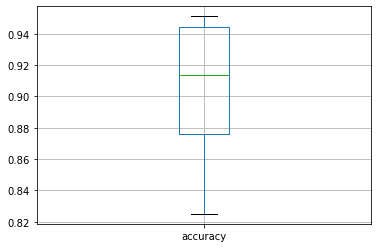

In [47]:
lr_df.boxplot()

### 4.4. Kernelized Support Vector Machines 

In [48]:
grid_search_param_svc = {
    "C": [10e-5,10e-4,10e-3,10e-2,10e-1,1.0,10,100,1000],
    "kernel":["linear","poly","rbf","sigmoid"]
}

cross_validation_set = StratifiedKFold(n_splits=10,shuffle=True)

In [49]:
grid_search_svc = GridSearchCV(estimator=svm.SVC(verbose=True),
                                param_grid=grid_search_param_svc,scoring="accuracy",cv=cross_validation_set,refit=True,
                                 verbose=2)

In [50]:
grid_search_svc.fit(dataset_X,dataset_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] C=0.0001, kernel=linear .........................................
[LibSVM][CV] .......................... C=0.0001, kernel=linear, total=   0.0s
[CV] C=0.0001, kernel=linear .........................................
[LibSVM][CV] .......................... C=0.0001, kernel=linear, total=   0.0s
[CV] C=0.0001, kernel=linear .........................................
[LibSVM][CV] .......................... C=0.0001, kernel=linear, total=   0.0s
[CV] C=0.0001, kernel=linear .........................................
[LibSVM][CV] .......................... C=0.0001, kernel=linear, total=   0.0s
[CV] C=0.0001, kernel=linear .........................................
[LibSVM][CV] .......................... C=0.0001, kernel=linear, total=   0.0s
[CV] C=0.0001, kernel=linear .........................................
[LibSVM][CV] .......................... C=0.0001, kernel=linear, total=   0.0s
[CV] C=0.0001, kernel=linear ........

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=SVC(verbose=True),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 1.0, 10, 100,
                               1000],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [51]:
grid_search_svc.best_score_

0.9085975609756097

In [52]:
svc_df = pd.DataFrame({'accuracy': cross_val_score( grid_search_svc.best_estimator_, dataset_X, dataset_y, cv=cross_validation_set),
                       'classifier': ['Support Vector Machine'] * 10})

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [53]:
svc_df.describe()

,accuracy
count,10.000000
mean,0.901524
std,0.048762
min,0.804878
25%,0.881250
50%,0.902439
75%,0.925000
max,0.975610


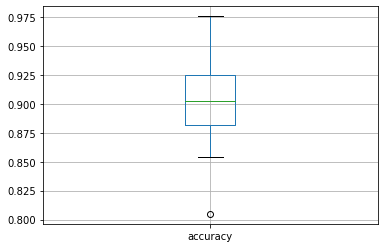

In [54]:
svc_df.boxplot()

### 4.5 XGBOOST

In [55]:
from xgboost import cv
from xgboost import DMatrix

In [56]:
xgb_data_matrix = DMatrix(data=dataset_X,label=dataset_y.astype(np.int16))

In [57]:
xgb_parameters = {
    
    'objective':'binary:logistic',
    'eval_metric':'error',
    'learning_rate':0.1
}
cross_validation_set = StratifiedKFold(n_splits=10,shuffle=True)

In [58]:
xgb_cv = cv(dtrain=xgb_data_matrix, params=xgb_parameters,nfold=10,stratified=True,folds=cross_validation_set,verbose_eval=True,
                    num_boost_round=100, metrics="error", as_pandas=True)

[0]	train-error:0.0541861+0.00292284	test-error:0.0937194+0.0327662
[1]	train-error:0.0514493+0.00529466	test-error:0.0862805+0.0355569
[2]	train-error:0.0506274+0.00348463	test-error:0.0862805+0.0355569
[3]	train-error:0.0470718+0.00583796	test-error:0.0837805+0.0335701
[4]	train-error:0.0448844+0.0059095	test-error:0.0789634+0.0291401
[5]	train-error:0.0426911+0.00459225	test-error:0.0814025+0.0274854
[6]	train-error:0.040503+0.00293894	test-error:0.0714634+0.0322467
[7]	train-error:0.0399543+0.00459499	test-error:0.0714634+0.0322467
[8]	train-error:0.039681+0.00426859	test-error:0.0689634+0.0308774
[9]	train-error:0.0402297+0.00406446	test-error:0.0689634+0.0308774
[10]	train-error:0.0383165+0.00407763	test-error:0.0664634+0.0270089
[11]	train-error:0.0369473+0.00551161	test-error:0.0689025+0.0263962
[12]	train-error:0.0372212+0.00522948	test-error:0.0664634+0.0270089
[13]	train-error:0.0353049+0.00465829	test-error:0.0664635+0.0247084
[14]	train-error:0.034209+0.0049315	test-error:

In [59]:
xgb_cv["train-accuracy-mean"] = 1-xgb_cv["train-error-mean"]
xgb_cv["test-accuracy-mean"] = 1-xgb_cv["test-error-mean"]

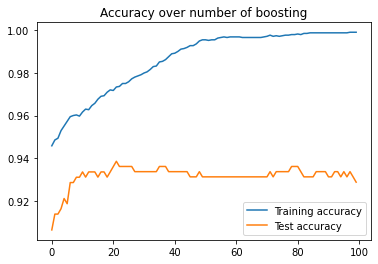

In [60]:
#plt.figure(figsize=(30,10))
plt.plot(range(xgb_cv.shape[0]),xgb_cv["train-accuracy-mean"],label="Training accuracy")
plt.plot(range(xgb_cv.shape[0]),xgb_cv["test-accuracy-mean"],label="Test accuracy")
plt.title("Accuracy over number of boosting")
plt.legend()
plt.show()

**We can clearly see some overfitting when the number of boosting become greater than 22. So we can prune at that level and consider as a training error and test error, the one obtained with 22 boosting trees.

In [61]:
xgb_cv.loc[21]

train-error-mean       0.026549
train-error-std        0.003496
test-error-mean        0.061463
test-error-std         0.024882
train-accuracy-mean    0.973451
test-accuracy-mean     0.938537
Name: 21, dtype: float64

**The performance of our XGBoost Model is then 93.8% of accuracy with a standard deviation of 2.48%**

## CONCLUSION : ENHANCEMENT POSSIBILITIES and CODE REPRODUCTIBILITY

### Enhancement steps

* We saw some kind of log linear relationship between variables. We can add logarithmic features and see what is the impact on our model
* We may do some error analysis and check where our model is doing errors and see how we can correct it

### Reproductible core code for Random Forest and XGBoost (Since they are the one with the highest score)

RUNNING RANDOM FOREST CLASSIFIER *** 
---------- Random Forest accuracy statistics --------------
        accuracy
count  10.000000
mean    0.918963
std     0.042768
min     0.829268
25%     0.902439
50%     0.925915
75%     0.950000
max     0.975610


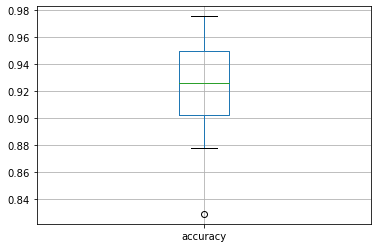

RUNNING XGBOOST CLASSIFIER *** 
---------- XGBOOST accuracy statistics --------------


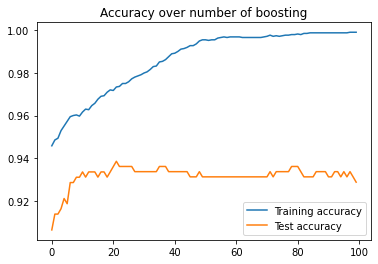

train-error-mean       0.026549
train-error-std        0.003496
test-error-mean        0.061463
test-error-std         0.024882
train-accuracy-mean    0.973451
test-accuracy-mean     0.938537
Name: 21, dtype: float64

In [62]:
#We import the necessary libraries

import sys
!{sys.executable} -m pip install xgboost

# This line tells the notebook to show plots inside of the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate,cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as sgb
from xgboost import XGBClassifier
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import warnings
warnings.filterwarnings('ignore')

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_b80070bd07dd4a969a7c5887d2fcc7a5 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Fun6Fce7MGPPA5oytlDCgPosswQZOeWCoO9LQ6rY2rPL',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_b80070bd07dd4a969a7c5887d2fcc7a5.get_object(Bucket='franckgemtest-donotdelete-pr-3b6m95pnwgrjka',Key='EMGrenoble_CarPerformance_Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
    
# We load our data and set the efficiency categories
df_data = pd.read_csv(body)
df_data.loc[df_data['mpg'] > 23.0,"car_efficiency"] = '1'
df_data.loc[df_data['mpg'] <= 23.0,"car_efficiency"] = '0'


dataset_clean = df_data

# Dealing with the null values

dataset_clean.loc[[10,11,12,13,16],"car_efficiency"]='0'
dataset_clean.loc[[254,260,323],"car_efficiency"]='1'


horsepower_mean_for_efficient_car = dataset_clean.loc[dataset_clean["car_efficiency"]=='1',"horsepower"].mean()
dataset_clean.loc[(dataset_clean["horsepower"].isna()) & (dataset_clean["car_efficiency"]=='1'),["horsepower"]] = horsepower_mean_for_efficient_car


horsepower_mean_for_non_efficient_car = dataset_clean.loc[dataset_clean["car_efficiency"]=='0',"horsepower"].mean()
dataset_clean.loc[(dataset_clean["horsepower"].isna()) & (dataset_clean["car_efficiency"]=='0'),["horsepower"]] = horsepower_mean_for_non_efficient_car

dataset_clean.drop(columns=["mpg","name"],inplace=True)

# Assertion on the elements in our clean dataset
assert len(dataset_clean['car_efficiency'].unique()) == 2
assert dataset_clean.shape[0] == 406
assert dataset_clean.shape[1] == 8

# Settings variables we will use to predict the target variable
explanatory_variables= ["acceleration","horsepower","weight","engine","cylinders","year","origin"]
to_predict = ["car_efficiency"]

# Creating dummies variables from categorical variables
dataset_X = pd.get_dummies(data=dataset_clean[explanatory_variables],columns=["origin"],prefix=["origin"],drop_first=False)
dataset_y = dataset_clean[to_predict]

# Settings parameters we will use for grid search
grid_search_param = {
    'criterion' : ("gini","entropy"),
    "n_estimators": [1,5,10,50,100,500],
    "min_samples_split":[3,5,11],
    "warm_start":(False,True)
}

#Setting folds for cross validation
cross_validation_set = StratifiedKFold(n_splits=10,shuffle=True)

grid_search_clf = GridSearchCV(estimator=RandomForestClassifier(),param_grid=grid_search_param,scoring="accuracy",
                               cv=cross_validation_set,refit=True,verbose=0)

# Fitting our model by looking in a range of values
print("RUNNING RANDOM FOREST CLASSIFIER *** ")
grid_search_clf.fit(dataset_X,dataset_y)
rf_df = pd.DataFrame({'accuracy': cross_val_score( grid_search_clf.best_estimator_, dataset_X, dataset_y, cv=cross_validation_set),
                       'classifier': ['Random Forest'] * 10})
# Printing the results

print("---------- Random Forest accuracy statistics --------------")
print(rf_df.describe())
rf_df.boxplot()
plt.show()
# Now we train the XGBoost model

xgb_data_matrix = DMatrix(data=dataset_X,label=dataset_y.astype(np.int16))

xgb_parameters = {
    
    'objective':'binary:logistic',
    'eval_metric':'error',
    'learning_rate':0.1
}
cross_validation_set = StratifiedKFold(n_splits=10,shuffle=True)

print("RUNNING XGBOOST CLASSIFIER *** ")
xgb_cv = cv(dtrain=xgb_data_matrix, params=xgb_parameters,nfold=10,stratified=True,folds=cross_validation_set,verbose_eval=False,
                    num_boost_round=100, metrics="error", as_pandas=True)

xgb_cv["train-accuracy-mean"] = 1-xgb_cv["train-error-mean"]
xgb_cv["test-accuracy-mean"] = 1-xgb_cv["test-error-mean"]

print("---------- XGBOOST accuracy statistics --------------")
plt.plot(range(xgb_cv.shape[0]),xgb_cv["train-accuracy-mean"],label="Training accuracy")
plt.plot(range(xgb_cv.shape[0]),xgb_cv["test-accuracy-mean"],label="Test accuracy")
plt.title("Accuracy over number of boosting")
plt.legend()
plt.show()

xgb_cv.loc[21]